## Load Python Libraries

In [239]:
import torch
from torchvision import transforms
import torchvision.models as models
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, Subset, SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold

### Get a list of peptides

In [240]:
peptide_score_file = './training_peptide_PSSM_scores.txt'

def load_peptide_data(infile):

    peptides = list()
    PSSM_score = list()

    with open(infile) as f:
        for line in f:
            peptide, score = line.strip().split()
            peptides.append(list(peptide))
            PSSM_score.append(float(score))

    return peptides, PSSM_score

peptides, PSSM_score = load_peptide_data(peptide_score_file)

## One-hot encoding of the pepetides

In [241]:
def one_hot_encode_peptides(peptides):
    flattened_peptides = np.array(peptides).flatten().reshape(-1, 1)

    # Initialize the OneHotEncoder
    encoder = OneHotEncoder(categories=[list('ACDEFGHIKLMNPQRSTVWY')], sparse_output=False)

    # Transform the peptide sequences into a one-hot encoded format
    one_hot_encoded = encoder.fit_transform(flattened_peptides)

    # Reshape back into the original peptide sequence format
    num_peptides = len(peptides)
    peptide_length = len(peptides[0])
    one_hot_encoded_peptides = one_hot_encoded.reshape(num_peptides, peptide_length, -1)

    return one_hot_encoded_peptides

one_hot_encoded_peptides = one_hot_encode_peptides(peptides)

## Defining the model used

In [242]:
# Define model
class Linear_NN(torch.nn.Module):

    # 180 is given from the one-hot encoding of the 20 amino acids * 9 peptide length
    def __init__(self):
        super(Linear_NN, self).__init__()
        self.fc1 = torch.nn.Linear(180, 90)
        self.fc2 = torch.nn.Linear(90, 50)
        self.fc3 = torch.nn.Linear(50, 1)
        # self.drop = torch.nn.Dropout(p=0.5)
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        # x = self.drop(x)
        out = self.fc3(x)
        return out

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Define function to reset weight
Weight resetting aid to prevent the weight leakage

In [243]:
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        print(f'reset weight of layer {m}')
        m.reset_parameters()

### Loss function and optimizer

In [244]:
# Define the loss function 
criterion = torch.nn.MSELoss()

In [245]:
peptides_tensor = torch.tensor(one_hot_encoded_peptides, dtype=torch.float32).to(device)
PSSM_score_tensor = torch.tensor(np.asarray(PSSM_score).reshape(-1,1), dtype=torch.float32).to(device)

peptides_dataset = TensorDataset(peptides_tensor, PSSM_score_tensor)

In [246]:
torch.manual_seed(69)

kfold = KFold(n_splits=5, shuffle=True)

print("Starting KFold Cross Validation")

for fold, (train_ids, test_ids) in enumerate(kfold.split(peptides_dataset)):
    
    print(f'Fold {fold+1}')

    # Shuffle the data
    train_subsampler = SubsetRandomSampler(train_ids)
    test_subsampler = SubsetRandomSampler(test_ids)

    # Define the data loaders
    train_loader = DataLoader(peptides_dataset, batch_size=10, sampler=train_subsampler)
    test_loader = DataLoader(peptides_dataset, batch_size=10, sampler=test_subsampler)

    # Initialize NN
    model = Linear_NN().to(device)
    model.apply(reset_weights)

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(0, 100):
    
            print(f'Epoch {epoch+1}')

            training_loss = 0.0

            for i, data in enumerate(train_loader):
                  
                # Get the inputs
                inputs, labels = data

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs.view(-1, 180))

                # Calculate the loss
                loss = criterion(outputs, labels)

                # Backward pass
                loss.backward()

                # Optimize
                optimizer.step()

                training_loss += loss.item()
            
            print(f'Training loss: {training_loss/len(train_loader)}')
        
    print('Finished Training, Saving Model')
    torch.save(model.state_dict(), f'./model/model_fold_{fold}.pt')

    with torch.no_grad():
        model.eval()
        validation_loss = 0.0

        for inputs, labels in test_loader:

            outputs = model(inputs.view(-1, 180))
            loss = criterion(outputs, labels)

            validation_loss += loss.item()
        
        print(f'Validation Loss: {validation_loss/len(test_loader)}')
    

Starting KFold Cross Validation
Fold 1
reset weight of layer Linear(in_features=180, out_features=90, bias=True)
reset weight of layer Linear(in_features=90, out_features=50, bias=True)
reset weight of layer Linear(in_features=50, out_features=1, bias=True)
Epoch 1
Training loss: 37.60453560773064
Epoch 2
Training loss: 32.21093099257525
Epoch 3
Training loss: 18.88384179507985
Epoch 4
Training loss: 5.928603088154512
Epoch 5
Training loss: 4.213452654726365
Epoch 6
Training loss: 2.9481542601304898
Epoch 7
Training loss: 2.1700775448013756
Epoch 8
Training loss: 1.6765680768910576
Epoch 9
Training loss: 1.2944391825619865
Epoch 10
Training loss: 0.9765576702706954
Epoch 11
Training loss: 0.7853609034243751
Epoch 12
Training loss: 0.6253439976888544
Epoch 13
Training loss: 0.5153585882747874
Epoch 14
Training loss: 0.4115923450273626
Epoch 15
Training loss: 0.32828473080607024
Epoch 16
Training loss: 0.24943224121542537
Epoch 17
Training loss: 0.19765381953295538
Epoch 18
Training loss

## Evaluating the model with unseen data

In [252]:
evaluation_data = './evaluation_peptide_PSSM_scores.txt'
# evaluation_data = '../data/data/PSSM/A0201.eval'
evaluation_peptides, evaluation_score = load_peptide_data(evaluation_data)
evaluation_one_hot_encoded_peptides = one_hot_encode_peptides(evaluation_peptides)

# Convert to tensors
evaluation_peptides_tensor = torch.tensor(evaluation_one_hot_encoded_peptides, dtype=torch.float32).to(device)
evaluation_score_tensor = torch.tensor(np.asarray(evaluation_score).reshape(-1,1), dtype=torch.float32).to(device)

evaluation_peptides_dataset = TensorDataset(evaluation_peptides_tensor, evaluation_score_tensor)


def test_model(models, evaluation_peptides_dataset):
    predictions = []

    evaluation_data_loader = DataLoader(evaluation_peptides_dataset, batch_size=10)

    with torch.no_grad():
        for model in models:
            model.eval()
            model_predictions = []

            for peptides, _ in evaluation_data_loader:
                peptides = peptides.to(device)
                outputs = model(peptides.view(-1, 180))
                model_predictions.extend(outputs.cpu().numpy())

            predictions.append(model_predictions)

    # Average predictions across models
    averaged_predictions = np.mean(predictions, axis=0)

    # Calculate total loss
    total_loss = criterion(torch.tensor(averaged_predictions, dtype=torch.float32).to(device), evaluation_score_tensor).item()

    return averaged_predictions, total_loss

# Load models
models = []
for i in range(5):
    model = Linear_NN().to(device)
    model.load_state_dict(torch.load(f'./model/model_fold_{i}.pt'))
    models.append(model)

# Test models
predictions, total_loss = test_model(models, evaluation_peptides_dataset)

print(f'Total Loss: {total_loss}')

for peptide, score, prediction in zip(evaluation_peptides, evaluation_score, predictions):
    print(f'{"".join(peptide)} {score} {prediction[0]}')

Total Loss: 14.369688034057617
ILYQVPFSV 8.957314258798739 7.39902400970459
VVMGTLVAL 3.516649456581935 4.414029121398926
ILDEAYVMA 4.393161125136994 4.635015964508057
KILSVFFLA 3.162495528678749 3.171699047088623
HLYQGCQVV 7.983249980843749 6.4596991539001465
YLDLALMSV 7.7676448891459104 6.915003776550293
ALAKAAAAA 3.1230469479298324 2.3007149696350098
MALLRLPLV 2.8711837044823403 3.1178040504455566
FLLTRILTI 6.85851979895127 6.715615749359131
ILSSLGLPV 6.318554640144165 6.554142951965332
RMYGVLPWI 7.085349552697065 5.730665683746338
ALPYWNFAT 3.3212699053395403 4.373442649841309
YLEPGPVTV 9.345369631407209 8.617523193359375
FLPWHRLFL 7.939361397738278 7.6753106117248535
LLPSLFLLL 7.249571368075748 7.518120765686035
MLQDMAILT 3.935708459540506 3.28619647026062
LVSLLTFMI 1.445987259319034 1.7720134258270264
GLMTAVYLV 6.876833959130511 7.098447322845459
ILTVILGVL 2.7551585708286046 2.8018953800201416
GLYSSTVPV 7.2035020560994525 7.333117485046387
SLYFGGICV 6.505421326387179 5.9935965538

PCC:  0.8855911850350184


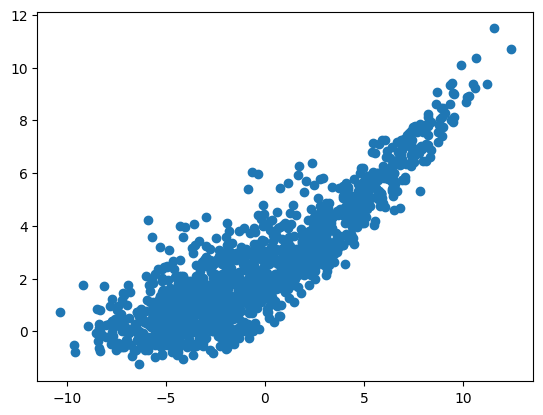

In [253]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

pcc = pearsonr(evaluation_score, np.array(predictions).flatten())
print("PCC: ", pcc[0])

plt.scatter(evaluation_score, predictions);